# NLP Predicting Disasters via Tweets

In this competition, we are challenged to build a machine learning model that predicts which tweets are referencing real disasters or not.

In [1]:
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from bs4 import BeautifulSoup
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchinfo import summary
import kagglehub
import keras
import keras_hub
from keras.callbacks import EarlyStopping

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data EDA + Analysis

When we look at the data, we should see 4 categories:
- Keyword (most relevant word in the text)
- Location 
- Text (tweet body text)
- Target (disaster no/yes represented as 0 and 1)

In [3]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

print(f'Train Shape: {train.shape}\n')
train.info()

Train Shape: (7613, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## NaN + Duplicated Values

Great! Now let's take a look at the distribution of non-disaster and disaster-relevant tweets (we want an even distribution).

Something to notice as well is that `keyword` and `location` are mostly blank, which we will have to take into account when we start our preprocessing journey

We will look at the number of NaN and duplicated values, as with them, our model might run worse.

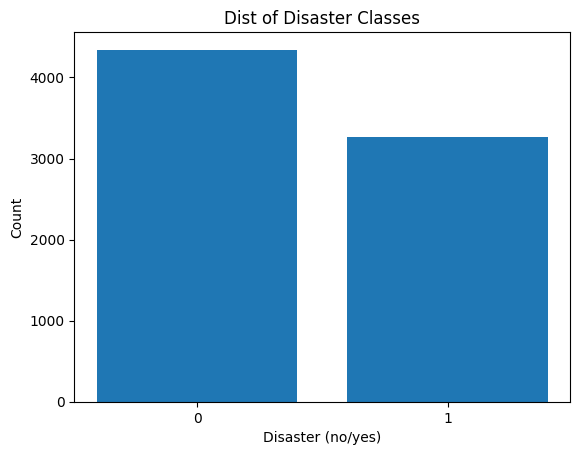

In [5]:
target_counts = train['target'].value_counts()

plt.bar(target_counts.index, target_counts.values)
plt.xticks([0, 1])
plt.xlabel('Disaster (no/yes)')
plt.ylabel('Count')
plt.title('Dist of Disaster Classes')
plt.show()

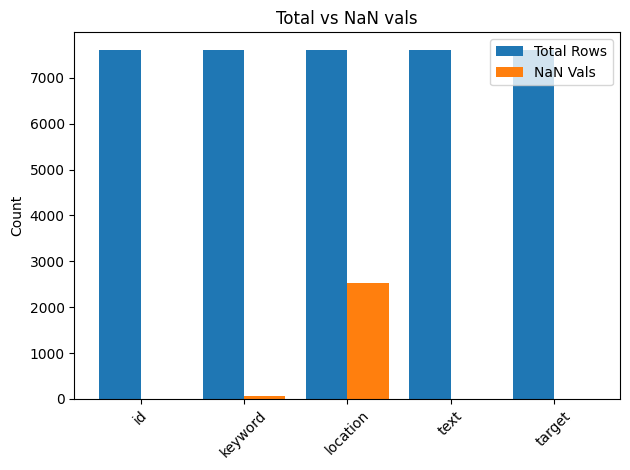

In [6]:
def plot_double_bar(x: np.ndarray, first: np.ndarray, second: np.ndarray, w=0.4, title='', f_label='', s_label=''):
    plt.bar(x - w/2, first, width=w, label=f_label)
    plt.bar(x + w/2, second, width=w, label=s_label)
    plt.xticks(x, train.columns, rotation=45)
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


null = train.isnull().sum()
total = len(train)

x = np.arange(len(train.columns))

plot_double_bar(x, [total]*len(null), null.values, title='Total vs NaN vals', f_label='Total Rows', s_label='NaN Vals')

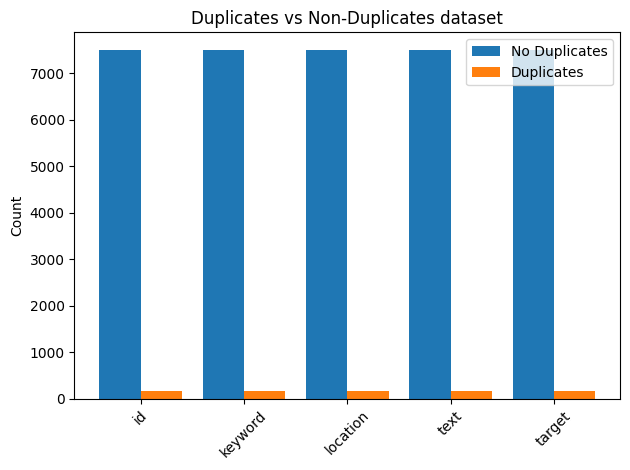

In [7]:
duplicates = train[train.duplicated(subset=['text'], keep=False)].sort_values(by='text')
non_duplicates = train.drop_duplicates(subset=['text'])

x = np.arange(len(train.columns))

plot_double_bar(x, [len(non_duplicates)] * len(train.columns), [len(duplicates)] * len(train.columns), title='Duplicates vs Non-Duplicates dataset', f_label='No Duplicates', s_label='Duplicates')


## Semantic Word Analysis

We are going to take a look at the most common words in each category (disaster / non-disaster tweets). 

Since we will be pre-processing data to find the keyword, we don't need to worry about this too hard. However it doesn't hurt to see the most common words before we extract keywords and remove stop words.

- Our outcome should be a bunch of random words (tweets have a small text box, so makes sense).
- We also do not have that many duplicates so there shouldn't be much of a difference between the two word clouds

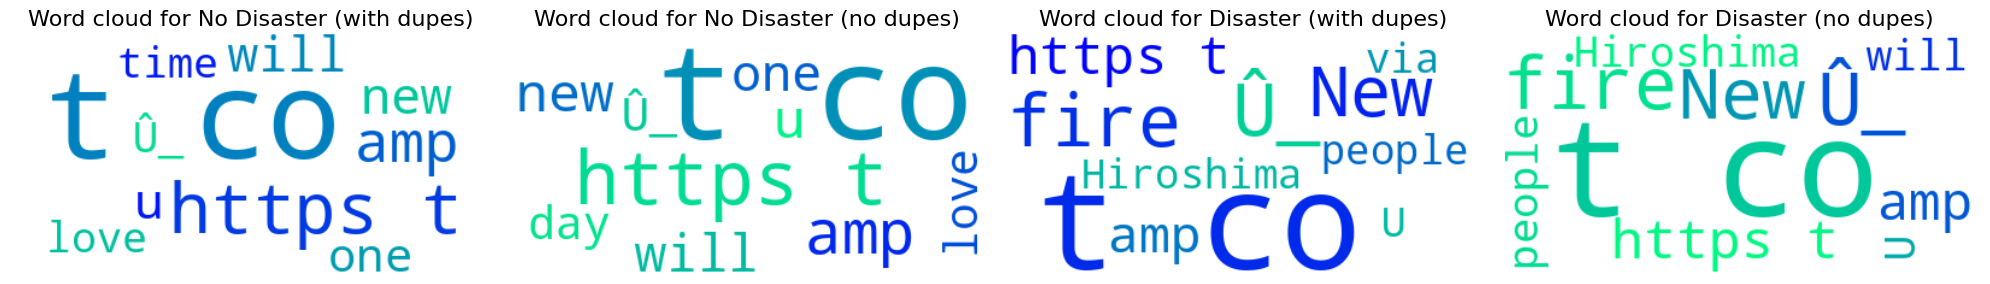

In [8]:
before_removal = train.groupby('target')['text'].apply(lambda x: ' '.join(x))
after_removal = non_duplicates.groupby('target')['text'].apply(lambda x: ' '.join(x))

def plot_wordcloud(cat: str, txt: str, ax: plt.axes):
    wordcloud = WordCloud(width=400, height=200, background_color='white', colormap='winter_r', max_words=10).generate(txt)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word cloud for {cat}', fontsize=16)
    ax.axis('off')

fig, axes = plt.subplots(1, len(before_removal)*2, figsize=(20, 10), sharex=True, sharey=True)

names = {0: 'No Disaster', 1: 'Disaster'}

for i, target in enumerate(before_removal.index):
    plot_wordcloud(f'{names[target]} (with dupes)', before_removal[target], axes[i * 2])
    plot_wordcloud(f'{names[target]} (no dupes)', after_removal[target], axes[i * 2 + 1])

plt.tight_layout()
plt.show()

# Pre-Processing Data

Now we can start to pre-process with the information gathered!
- We have a lot of NaN values in our `keywords` and `location` categories, so we will need to predict the most important word
    - Removing stopwords / stemming words if no hashtag
    - TF-IDF ranking of words in our tweet body to get our keyword

In [9]:
# get rid of duplicates
pp_train = train.drop_duplicates(subset=['text'])

## TF-IDF Ranking for Keywords / Location

When we feed this dataset through our model, having keywords and locations will boost the accuracy (like with humans, when we are given earthquake and saskatoon we would know theres an earthquake in saskatoon)
- The way I decided to preprocess was through **TF-IDF**, more specifically IDF, as it will elevate specific/rare words such as `explosion, earthquake` over simple words.
    - We use `nlp` to tokenize our words, then **lemmatize** them (reduce to smallest form as long as its a letter and is not a stopword)
    - We then feed this information into our **TF-IDF** vectorizer to calculate how relevant our word is to the other tweets (and how specific/rare the word is)
        - When we look through our vectorizer, we check if it's a location (`nlp` will designate it as a `'GPE'`), if so we can add that to our location datatype.

In [10]:
# Get TF-IDF ranking of words to fill in our `keyword` and `location` datapoints

# Preprocess our text setup
nlp = spacy.load('en_core_web_sm')

def preprocess(txt):
    doc = nlp(txt.lower())
    return ' '.join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop]) # remove stopwords and lemmatize them!

pp_train['processed_text'] = pp_train['text'].apply(preprocess)

pp_train['processed_text']

<ipython-input-10-f2c69f6bcfb9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_train['processed_text'] = pp_train['text'].apply(preprocess)


0                    deed reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       people receive wildfire evacuation order calif...
4       get send photo ruby alaska smoke wildfire pour...
                              ...                        
7604    worldnew fall powerline g link tram update fir...
7605           flip walmart bomb evacuate stay tuned blow
7606    suicide bomber kill saudi security site mosque...
7608         giant crane hold bridge collapse nearby home
7612    late home raze northern california wildfire ab...
Name: processed_text, Length: 7503, dtype: object

## TF-IDF Bias

Before we get into the actual TF-IDF vectorization, we need to address the fact we currently have a **bias** towards disaster-related words. For example, TF-IDF might classify words like `ronge` as a *rare* word over `earthquake`. We should use some keywords used the most so we know (for example, our word cloud saw `fire` as a common word, but that only fits a specific use case).

Creating a list of words would be tedious and lead to a lack of generalization, so I have opted to use [this website](https://relatedwords.io/disaster) (relatedwords.io) to grab words relevant to disasters/tragedies.

In [11]:
# get website

def get_keywords(topic: str) -> List:
    related_words = []
    link = f'https://relatedwords.io/{topic}'

    try:
        response = requests.get(link, timeout=5)
        response.raise_for_status()
    except requests.Timeout:
        print(f'Timeout Error: {e}')
    except requests.RequestException as e:
        print(f'Request failed: {e}')

    # use soup to extract all words!
    soup = BeautifulSoup(response.content, 'html.parser')

    for a in soup.find_all('a'):
        word = a.text.strip().lower()
        if word.isalpha():
            related_words.append(word)

    return [preprocess(word) for word in related_words]


topics = ['disaster', 'terrorism', 'war']
keywords = []

for topic in topics:
    keywords.extend(get_keywords(topic))

keywords = {word for word in keywords if word}

print(sorted(list(keywords))[:40])
print('Size:', len(keywords))

['abb', 'abuse', 'abusive', 'accident', 'accuse', 'act', 'action', 'active', 'activity', 'adventure', 'adversity', 'advocate', 'affair', 'affect', 'afflict', 'affliction', 'afghanistan', 'aftermath', 'agency', 'agenda', 'aggravation', 'aggression', 'agile', 'ago', 'aiai', 'aid', 'ail', 'aim', 'algeria', 'alien', 'alir', 'allege', 'ally', 'amalthea', 'ambassador', 'annihilation', 'ano', 'ant', 'antagonism', 'anti']
Size: 947


In [12]:
# TF-IDF
vector = TfidfVectorizer()
X = vector.fit_transform(pp_train['processed_text'])
vocab = vector.get_feature_names_out()

loc_words = set()
docs = list(nlp.pipe([f'I am in {w}' for w in vocab]))
for word, doc in zip(vocab, docs):
    if any(ent.label_ == 'GPE' for ent in doc.ents):
        loc_words.add(word)

def get_key(text, r_idx, loc=False):
    og_tokens = set(text.iloc[r_idx].split())
    row = X[r_idx].toarray()[0]
    sorted_idx = row.argsort()[::-1] # take largest
    for idx in sorted_idx:
        can = vocab[idx]
        if not loc and can in keywords and can in og_tokens: # if we want keyword
            return can
        elif loc and can in loc_words and can in og_tokens: # if we want location
            return can
    return 'No Keyword'




pp_train['keyword'] = [get_key(pp_train['processed_text'], i) for i in range(len(pp_train))]
pp_train['location'] = [get_key(pp_train['processed_text'], i, True) for i in range(len(pp_train))]

<ipython-input-12-d9941ee69877>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_train['keyword'] = [get_key(pp_train['processed_text'], i) for i in range(len(pp_train))]
<ipython-input-12-d9941ee69877>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_train['location'] = [get_key(pp_train['processed_text'], i, True) for i in range(len(pp_train))]


In [13]:
pp_train

,id,keyword,location,text,target,processed_text
0,1,earthquake,No Keyword,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,4,fire,canada,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,evacuation,No Keyword,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,evacuation,california,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,school,alaska,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7604,10863,link,No Keyword,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnew fall powerline g link tram update fir...
7605,10864,bomb,No Keyword,on the flip side I'm at Walmart and there is a...,1,flip walmart bomb evacuate stay tuned blow
7606,10866,security,No Keyword,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kill saudi security site mosque...
7608,10869,collapse,No Keyword,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home


# Model Training

## Model #1: Logistic Regression & XGBoost

Our benchmark model will be a simple logistic regression algorithm. Setting this model up should be relatively simple, other than encoding our data such that it fits linearly (only numbers, no text, in a 1D array).

We will also use XGBoost, which works as an ensemble of decision trees (nonlinear). This should net in a higher accuracy as it will be better at learning complex patterns.

In [14]:
# process data 
X = vector.transform(pp_train['processed_text']) # text -> tf-idf since we can't use text in log reg

encoder = OneHotEncoder(handle_unknown='ignore')
X_kw = encoder.fit_transform(pp_train[['keyword', 'location']])

X_full = hstack([X, X_kw])

In [15]:
# split data into train, test, val
X_temp, X_test, y_temp, y_test = train_test_split(X_full, 
                                                    pp_train['target'], test_size=0.15,
                                                    stratify=pp_train['target'])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.1765, stratify=y_temp)

xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)
xgb_val = xgb.DMatrix(X_val, y_val, enable_categorical=True)

print(f'Train (70%): {X_train.shape}')
print(f'Test (15%): {X_test.shape}')
print(f'Val (15%): {X_val.shape}')

Train (70%): (5251, 12244)
Test (15%): (1126, 12244)
Val (15%): (1126, 12244)


In [16]:
# logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

n = 1000
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.3,
    'booster': 'gbtree',
    'verbosity': 1,
}

xg_model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=n, early_stopping_rounds=20, evals=[(xgb_val, 'val')])

[0]	val-logloss:0.63887
[1]	val-logloss:0.61543
[2]	val-logloss:0.59944
[3]	val-logloss:0.59028
[4]	val-logloss:0.58075
[5]	val-logloss:0.57628
[6]	val-logloss:0.56972
[7]	val-logloss:0.56488
[8]	val-logloss:0.56080
[9]	val-logloss:0.55631
[10]	val-logloss:0.55185
[11]	val-logloss:0.54856
[12]	val-logloss:0.54587
[13]	val-logloss:0.54240
[14]	val-logloss:0.53999
[15]	val-logloss:0.53683
[16]	val-logloss:0.53282
[17]	val-logloss:0.53194
[18]	val-logloss:0.52980
[19]	val-logloss:0.52835
[20]	val-logloss:0.52724
[21]	val-logloss:0.52503
[22]	val-logloss:0.52476
[23]	val-logloss:0.52211
[24]	val-logloss:0.52116
[25]	val-logloss:0.51925
[26]	val-logloss:0.51829
[27]	val-logloss:0.51805
[28]	val-logloss:0.51706
[29]	val-logloss:0.51677
[30]	val-logloss:0.51450
[31]	val-logloss:0.51234
[32]	val-logloss:0.51101
[33]	val-logloss:0.50897
[34]	val-logloss:0.50868
[35]	val-logloss:0.50899
[36]	val-logloss:0.50897
[37]	val-logloss:0.50690
[38]	val-logloss:0.50594
[39]	val-logloss:0.50551
[40]	val-l

In [17]:
# log reg model
y_val_pred = lr_model.predict(X_val)
print('Val Performance:\n', classification_report(y_val, y_val_pred))

y_test_pred = lr_model.predict(X_test)
print('Test Performance:\n', classification_report(y_test, y_test_pred))

Val Performance:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       646
           1       0.80      0.65      0.72       480

    accuracy                           0.78      1126
   macro avg       0.78      0.76      0.77      1126
weighted avg       0.78      0.78      0.78      1126

Test Performance:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       646
           1       0.80      0.70      0.74       480

    accuracy                           0.80      1126
   macro avg       0.80      0.78      0.79      1126
weighted avg       0.80      0.80      0.79      1126



In [18]:
# xg model
xgb_y_val_pred = (xg_model.predict(xgb_val) >= 0.5).astype(int)
print('Val Performance:\n', classification_report(y_val, xgb_y_val_pred))

xgb_y_test_pred = (xg_model.predict(xgb_test) >= 0.5).astype(int)
print('Test Performance:\n', classification_report(y_test, xgb_y_test_pred))

Val Performance:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82       646
           1       0.79      0.66      0.72       480

    accuracy                           0.78      1126
   macro avg       0.78      0.76      0.77      1126
weighted avg       0.78      0.78      0.77      1126

Test Performance:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       646
           1       0.77      0.68      0.72       480

    accuracy                           0.78      1126
   macro avg       0.77      0.76      0.77      1126
weighted avg       0.77      0.78      0.77      1126



## Model #1 Overview

As we can see, Linear Regression gives us an accuracy of **75-78%** for the test and validation sets. XGBoost gives us about **76-79%**.

For the use case of predicting disasters, this isn't a terrible start, but also isn't sufficient. Since regression algorithms struggle with temporal and contextual relationships, we could move on to another model, such as an LSTM.

## Model #2: LSTM

In essence, this is going to be a RNN that can learn when to remember and forget info over time (cell and hidden states).

Since this will remember only the most important words, and remember the context behind them, it will become hopefully easier to extract important words and define whether there is a disaster or not.

Our first step should be to **tokenize** our words and pad them so they are all equal length, then we need to **encode** our keyword and location words so the LSTM can read them.

In [19]:
# tokenized words
def create_vocab(tokens):
    every_token = [word for tweet in tokens for word in tweet]
    word_counts = Counter(every_token)

    vocab = {word: idx+2 for idx, (word, _) in enumerate(word_counts.items())}
    vocab['<pad>'] = 0 # padding for same-length words
    vocab['<unk>'] = 1 # unknown

    return vocab

def tokenize(tweets: pd.Series):
    tokens = [text.split() for text in tweets]
    vocab = create_vocab(tokens)
    print(f'Vocabulary: {list(vocab.items())[:5]}')

    encoded = [[vocab.get(word, vocab['<unk>']) for word in tweet] for tweet in tokens]

    padded = pad_sequence([torch.tensor(seq) for seq in encoded], batch_first=True, padding_value=vocab['<pad>'])
    return padded, len(vocab)

In [20]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, df):
        self.df = df # preprocessed dataframe
        self.text, self.vocab_size = tokenize(df['processed_text'])

        kw_enc, lc_enc = LabelEncoder(), LabelEncoder()
        self.keywords = kw_encoded = torch.tensor(kw_enc.fit_transform(self.df['keyword']))
        self.locations = lc_encoded = torch.tensor(lc_enc.fit_transform(self.df['location']))

        print(f'Keywords: {kw_encoded[:5]}, Locations: {lc_encoded[:5]}')
                
        self.labels = torch.tensor(df['target'].values, dtype=torch.float32)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': self.text[idx],
            'keyword': self.keywords[idx],
            'location': self.locations[idx],
        }, self.labels[idx]

In [21]:
ds = DisasterTweetsDataset(pp_train)

Vocabulary: [('deed', 2), ('reason', 3), ('earthquake', 4), ('allah', 5), ('forgive', 6)]
Keywords: tensor([151, 185, 165, 165, 403]), Locations: tensor([ 0, 67,  0, 64, 10])


In [22]:
# train, test, val indices
train_size = int(0.7 * len(ds))
val_size = int(0.15 * len(ds))
test_size = len(ds) - train_size - val_size

train_i, val_i, test_i = random_split(ds, [train_size, val_size, test_size])

# batch processing
train_dl = DataLoader(train_i, batch_size=32, shuffle=True)
val_dl = DataLoader(val_i, batch_size=32)
test_dl = DataLoader(test_i, batch_size=32)

print(f'Train Size: {len(train_dl.dataset)}')
print(f'Val Size: {len(val_dl.dataset)}')

Train Size: 5252
Val Size: 1125


Now that we have tokenized our model, and created the dataset, let's create our model. Our model will consist of:
- Embedding layers to learn relationships behind our encoded words (tweets, keywords, locations)
- An LSTM layer to learn temporal and contextual meanings behind each category
- A linear and sigmoid layer to output our hidden dimension, or rather, whether we classify the tweet as a disaster tweet or not

In [23]:
class DisasterModel(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, kw_vocab_size: int, loc_vocab_size: int):
        '''
            Args:
                vocab_size: # of tweets in our vocabulary
                embed_dim: how much semantic vector space for each token gets to represent features
                hidden_dim: how much memory the lstm has
                kw_vocab_size: # of keywords in our vocabulary
                loc_vocab_size: # of locations in our vocabulary
        '''
        super().__init__()
        # embeddings
        self.txt_embed = nn.Embedding(vocab_size, embed_dim)
        self.kw_embed = nn.Embedding(kw_vocab_size, 8)
        self.loc_embed = nn.Embedding(loc_vocab_size, 8)

        # lstm + dropout, important for our tweet txt
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)

        # final layers for disaster / no disaster
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 8 + 8, 1),
            nn.Sigmoid()
        )

    def forward(self, txt, kw, loc):
        # take tweet txt and feed it through our lstm
        x = self.txt_embed(txt)
        x, _ = self.lstm(x)
        x = torch.max(x, dim=1).values # take most informative
        x = self.dropout(x)

        # take keyword and location and embed it
        kw_vec = self.kw_embed(kw)
        loc_vec = self.loc_embed(loc)

        # combine all of them and pass them through our decision layers
        combined = torch.cat([x, kw_vec, loc_vec], dim=1)
        return self.fc(combined).squeeze(1)
        
        

In [24]:
lstm_model = DisasterModel(ds.vocab_size, 64, 32, len(ds.keywords), len(ds.locations)).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.05)
lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # if lr doesn't change 5 epochs in, lower

params = {
    'epochs': 10,
    'optimizer': optimizer,
    'lr_scheduler': lr,
    'weight_path': 'lstm_weights.pt',
    'loss_fn': nn.BCELoss(),
    'patience': 7, # early stopping!
}

summary(lstm_model, input_data=(
    torch.randint(0, ds.vocab_size, (32, 40)).to(device), # 32 tweets, padded to 40 tokens
    torch.randint(0, len(ds.keywords), (32,)).to(device), # 32 keywords
    torch.randint(0, len(ds.locations), (32,)).to(device) # 32 locations
    )
)

Layer (type:depth-idx)                   Output Shape              Param #
DisasterModel                            [32]                      --
├─Embedding: 1-1                         [32, 40, 64]              727,552
├─LSTM: 1-2                              [32, 40, 64]              25,088
├─Dropout: 1-3                           [32, 64]                  --
├─Embedding: 1-4                         [32, 8]                   60,024
├─Embedding: 1-5                         [32, 8]                   60,024
├─Sequential: 1-6                        [32, 1]                   --
│    └─Linear: 2-1                       [32, 1]                   81
│    └─Sigmoid: 2-2                      [32, 1]                   --
Total params: 872,769
Trainable params: 872,769
Non-trainable params: 0
Total mult-adds (M): 59.24
Input size (MB): 0.01
Forward/backward pass size (MB): 1.32
Params size (MB): 3.49
Estimated Total Size (MB): 4.82

In [25]:
def train(model, dl, loss_fn, opt, device):
    model.train()
    total_loss = 0
    
    for batch, (X, y) in enumerate(dl):
        # unpacking
        txt = X['text'].to(device)
        kw = X['keyword'].to(device)
        loc = X['location'].to(device)
        y = y.to(device).float()

        # forward prop
        output = model(txt, kw, loc)
        loss = loss_fn(output, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dl)
        

def val(model, dl, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X, y in dl:
            # unpack
            txt = X['text'].to(device)
            kw = X['keyword'].to(device)
            loc = X['location'].to(device)
            y = y.to(device)

            # forward prop
            output = model(txt, kw, loc)
            loss = loss_fn(output, y)
            total_loss += loss.item()

            # get predictions / labels for classification report
            preds = (output >= 0.5).long().cpu()
            all_preds.extend(preds)
            all_labels.extend(y.cpu())

    return total_loss / len(dl), f1_score(all_labels, all_preds)
            

In [26]:
def train_val(model, train_dl, val_dl, params):
    best_val_loss = float('inf')
    patience_counter = 0

    loss_fn = params['loss_fn']
    optimizer = params['optimizer']
    patience = params['patience']
    epochs = params['epochs']
    lr_scheduler = params['lr_scheduler']

    train_losses = []
    val_losses = []
    f1s = []

    
    for epoch in range(epochs):
        train_loss = train(lstm_model, train_dl, loss_fn, optimizer, device)
        val_loss, f1 = val(lstm_model, val_dl, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        f1s.append(f1)
        

        print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4} | Val F1: {f1:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(lstm_model.state_dict(), params['weight_path'])
            print('New best model.')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Stopping early')
                break
        lr_scheduler.step(val_loss)

    return train_losses, val_losses

In [27]:
train_loss_index, val_loss_index = train_val(lstm_model, train_dl, val_dl, params)

Epoch: 1 | Train Loss: 0.6058 | Val Loss: 0.5191 | Val F1: 0.6390
New best model.
Epoch: 2 | Train Loss: 0.4358 | Val Loss: 0.5559 | Val F1: 0.6675
Epoch: 3 | Train Loss: 0.3597 | Val Loss: 0.5891 | Val F1: 0.6931
Epoch: 4 | Train Loss: 0.3135 | Val Loss: 0.5855 | Val F1: 0.7042
Epoch: 5 | Train Loss: 0.2862 | Val Loss: 0.6211 | Val F1: 0.6928
Epoch: 6 | Train Loss: 0.2682 | Val Loss: 0.7138 | Val F1: 0.7038
Epoch: 7 | Train Loss: 0.2497 | Val Loss: 0.6901 | Val F1: 0.6703
Epoch: 8 | Train Loss: 0.2004 | Val Loss: 0.7815 | Val F1: 0.6789
Stopping early


In [28]:
# testing
lstm_model.eval()
loss_func = params['loss_fn']

labels = []
all_preds = []
total_loss = 0

with torch.no_grad():
    for X, y in test_dl:
       # unpack
        txt = X['text'].to(device)
        kw = X['keyword'].to(device)
        loc = X['location'].to(device)
        y = y.to(device)

        # forward prop
        output = lstm_model(txt, kw, loc)
        loss = loss_func(output, y)
        total_loss += loss.item()

        # get predictions / labels for classification report
        preds = (output >= 0.5).long().cpu()
        all_preds.extend(preds)
        labels.extend(y.cpu())
        
print(f'Test Loss: {total_loss / len(test_dl)}\n{classification_report(labels, all_preds)}')

Test Loss: 0.7742173783481121
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       660
         1.0       0.68      0.71      0.70       466

    accuracy                           0.74      1126
   macro avg       0.73      0.74      0.74      1126
weighted avg       0.74      0.74      0.74      1126



## Model #2 Overview

LSTM gives us a **77%** accuracy on our testing data, it does not do much better than our current best model, which is our Logistic Regression model. Why does this happen?
- A reason could be the cleanliness of the dataset (after preprocessing) enabling the logistic regression to do just as well as our LSTM.
- We also notice that our LSTM overfits quite early on, perhaps that is due to the small amount of data trained on our LSTM (only about 7000+ tweets).
- Our model's ability to predict a disasterous tweet correctly has a much lower `f1-score` than non-disasterous tweets.

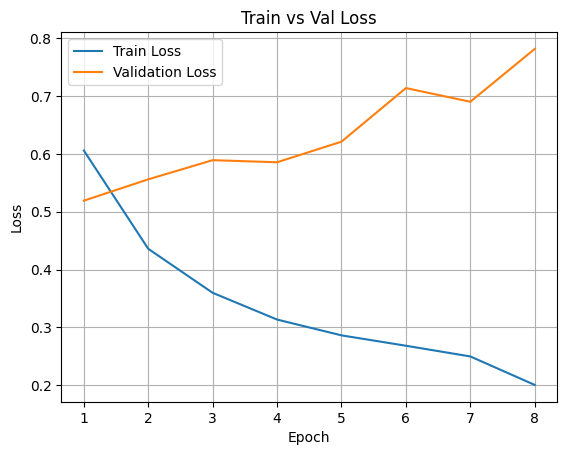

In [29]:
plt.plot(range(1, len(train_loss_index)+1), train_loss_index, label='Train Loss')
plt.plot(range(1, len(val_loss_index)+1), val_loss_index, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.grid(True)

## Model #3: DistilBERT

Our model could benefit from a pretrained model rather than an LSTM learning from scratch, such as DistilBERT.

BERT will tokenize our words for us, so we do not need to feed it preprocessed data, rather the 3 categories we obtained (`text`, `keyword`, `location`).

Since this dataset is small, we learnt the model will overfit early, so early stopping is crucial here.

In [30]:
preprocessor = keras_hub.models.DistilBertPreprocessor.from_preset('distil_bert_base_en_uncased', 
                                                                   sequence_length=128)

classifier = keras_hub.models.DistilBertClassifier.from_preset('distil_bert_base_en_uncased', 
                                                               num_classes=1,
                                                               preprocessor=preprocessor)

classifier.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

classifier.summary()

Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,954,241 (255.41 MB)

 Trainable params: 66,954,241 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

Since DistilBERT will do the tokenization for us, we just need to feed it the raw text, keywords, and locations.

In [31]:
combined_text = ('keyword: ' + pp_train['keyword'] + 
                 ' location: ' + pp_train['location'] + 
                 ' text: ' + pp_train['text'])

# resplit data, this time with our combined text
X_temp, X_test, y_temp, y_test = train_test_split(combined_text, pp_train['target'], test_size=0.15, stratify=pp_train['target'])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = classifier.fit(x=X_train.tolist(), y=y_train.astype('float32').values, 
               validation_data=(X_val.tolist(), y_val.astype('float32').values), 
               batch_size=32, epochs=10, callbacks=[early_stop])

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 90s 339ms/step - accuracy: 0.6475 - loss: 0.5904 - val_accuracy: 0.8321 - val_loss: 0.3993
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.8281 - loss: 0.4137 - val_accuracy: 0.8464 - val_loss: 0.3831
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 191ms/step - accuracy: 0.8582 - loss: 0.3585 - val_accuracy: 0.8446 - val_loss: 0.3954
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 32s 191ms/step - accuracy: 0.8791 - loss: 0.3193 - val_accuracy: 0.8481 - val_loss: 0.3954


## Model #3 Overview

We can see a huge leap in performance from a pretrained model to our custom LSTM despite the longer time to compute.

Our model seems to misclassify disasterous tweets as a non-disasterous tweet the most, (`f-score` is 87 versus 80). Accuracy is the highest though, at 84%.

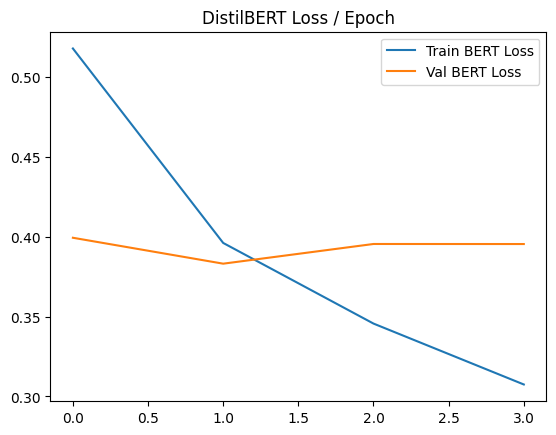

In [32]:
plt.plot(history.history['loss'], label='Train BERT Loss')
plt.plot(history.history['val_loss'], label='Val BERT Loss')
plt.title('DistilBERT Loss / Epoch')
plt.legend()

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step


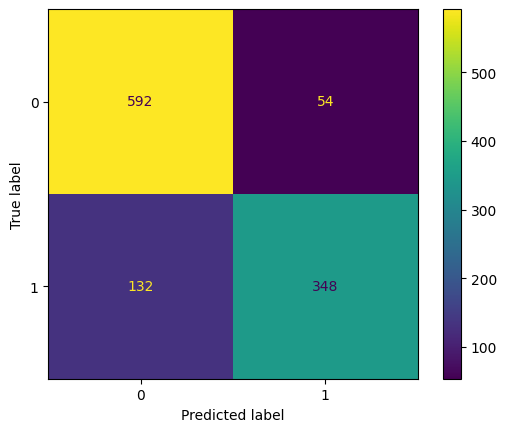

In [33]:
y_pred = classifier.predict(X_test.tolist())
y_pred_lbls = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_lbls)
ConfusionMatrixDisplay(cm).plot()

In [34]:
print(classification_report(y_test, y_pred_lbls))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86       646
           1       0.87      0.72      0.79       480

    accuracy                           0.83      1126
   macro avg       0.84      0.82      0.83      1126
weighted avg       0.84      0.83      0.83      1126



# Model Comparisons
If we combine all the models performance together, we should see that the pretrained model does the best (which makes sense, it's trained on a much larger database). However, in terms of speed, Logistic Regression would actually be the better option, as it suprisingly loses very little accuracy (slight precision change).

In [35]:
def predict_lstm(model, dl, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dl:
            X, y = batch
            txt = X['text'].to(device)
            kw = X['keyword'].to(device)
            loc = X['location'].to(device)

            outputs = model(txt, kw, loc)
            preds = (outputs > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y)
    return np.array(all_preds), np.array(all_labels)

In [36]:
# data for log reg
def convert_to_lr_model(df, processed_txt_name: str):
    X = vector.transform(df[processed_txt_name]) # text -> tf-idf since we can't use text in log reg

    X_kw = encoder.transform(df[['keyword', 'location']])

    return hstack([X, X_kw])

_, X_test_lr, _, y_test_lr = train_test_split(convert_to_lr_model(pp_train, 'processed_text'), 
                                        pp_train['target'], test_size=0.15,
                                        stratify=pp_train['target'])

In [37]:
# DISTILBERT MODEL
y_pred_bert = classifier.predict(X_test.tolist())
y_pred_lbls_bert = (y_pred_bert > 0.5).astype(int)

# LSTM MODEL
y_pred_lbls_lstm, y_true_lstm = predict_lstm(lstm_model, test_dl, device)

# LOG REGRESSION MODEL
y_pred_log = lr_model.predict(X_test_lr)



print('---------- DISTILBERT MODEL ----------\n',classification_report(y_test, y_pred_lbls_bert))
print('---------- LSTM MODEL ----------\n',classification_report(y_true_lstm, y_pred_lbls_lstm))
print('---------- LOG REG MODEL ----------\n',classification_report(y_test_lr, y_pred_log))

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
---------- DISTILBERT MODEL ----------
               precision    recall  f1-score   support

           0       0.82      0.92      0.86       646
           1       0.87      0.72      0.79       480

    accuracy                           0.83      1126
   macro avg       0.84      0.82      0.83      1126
weighted avg       0.84      0.83      0.83      1126

---------- LSTM MODEL ----------
               precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       660
         1.0       0.68      0.71      0.70       466

    accuracy                           0.74      1126
   macro avg       0.73      0.74      0.74      1126
weighted avg       0.74      0.74      0.74      1126

---------- LOG REG MODEL ----------
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       646
           1       0.88      0.77      0.82       480

    accuracy                   

# Submission

Overall, seeing logistic regression and a pre-trained BERT model perform closely in this scenario was quite interesting. This further highlights the importance of data processing, and how it can be used to create accurate ML models that can be compared to deep learning models such as LSTMS or DistilBERT

In [38]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(f'Train Shape: {test.shape}\n')
test.info()

Train Shape: (3263, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [39]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [40]:
# preprocess text to get keyword + location
test['pp_txt'] = test['text'].apply(preprocess)

# TF-IDF
X = vector.transform(test['pp_txt'])
vocab = vector.get_feature_names_out()

loc_words = set()
docs = list(nlp.pipe([f'I am in {w}' for w in vocab]))
for word, doc in zip(vocab, docs):
    if any(ent.label_ == 'GPE' for ent in doc.ents):
        loc_words.add(word)

test['keyword'] = [get_key(test['pp_txt'], i) for i in range(len(test))]
test['location'] = [get_key(test['pp_txt'], i, True) for i in range(len(test))]

test

,id,keyword,location,text,pp_txt
0,0,terrible,No Keyword,Just happened a terrible car crash,happen terrible car crash
1,2,earthquake,No Keyword,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,fire,No Keyword,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,apocalypse,No Keyword,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,typhoon,taiwan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...
3258,10861,earthquake,No Keyword,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fastener ...
3259,10865,worse,No Keyword,Storm in RI worse than last hurricane. My city...,storm ri worse hurricane hard hit yard look li...
3260,10868,derailment,chicago,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,weather,No Keyword,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo


In [41]:
combined_text = ('keyword: ' + test['keyword'] + 
                 ' location: ' + test['location'] + 
                 ' text: ' + test['text'])

submission_log = lr_model.predict(convert_to_lr_model(test, 'pp_txt'))
submission_bert = (classifier.predict(combined_text) > 0.5).astype(int)

submission_log_df = pd.DataFrame({
    'id': test['id'],
    'target': submission_log
})

submission_bert_df = pd.DataFrame({
    'id': test['id'],
    'target': submission_bert.flatten()
})

submission_log_df.to_csv('submission_log.csv', index=False)
submission_bert_df.to_csv('submission_bert.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step


In [42]:
submission_log_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [43]:
submission_bert_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
